In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

import itertools
from functools import partial

DATA_DIR = Path("/content/drive/My Drive/SH/data")

tf.keras.backend.clear_session()
tf.__version__

'2.1.0'

In [0]:
# Radial basis activation function: e^(-x^2)
@tf.function
def rbf(x):
    return tf.exp(-tf.pow(x, 2))

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(1,
                       use_bias=False,
                       input_shape=(2,),
                       activation=rbf)
])
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

<tf.Variable 'UnreadVariable' shape=(2, 1) dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [0]:
#model.compile(loss="mse", optimizer="sgd", metrics=["binary_accuracy"])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=.7), metrics=["accuracy"])

In [0]:
y = np.array([
    1,
    1,
    0,
    0
])
x = np.array([
    (0, 0),
    (2, 2),
    (2, 0),
    (0, 2)
])
x, y

(array([[0, 0],
        [2, 2],
        [2, 0],
        [0, 2]]), array([1, 1, 0, 0]))

In [0]:
def compute_subgoals(initial, goal, N, model, x):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return model.predict(x)

    subgoal_weights = tf.expand_dims(tf.linspace(0., 1, N), axis=-1) * (goal - initial) + initial

    subgoals = tf.stack([predict_for_weights(weights, x) for weights in subgoal_weights])
    subgoals = tf.squeeze(subgoals)
    
    return subgoal_weights, subgoals


initial = tf.constant([1., 1])
goal = tf.constant([1., -1])
N = 10 # number of subgoals

weights, subgoals = compute_subgoals(initial, goal, N, model, x)

subgoals

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[1.00000000e+00, 1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.00000000e+00, 3.23340305e-06, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 6.25832836e-05, 1.83156393e-02, 2.90960461e-01],
       [1.00000000e+00, 8.15988577e-04, 1.83156393e-02, 6.41180396e-01],
       [1.00000000e+00, 7.16697192e-03, 1.83156393e-02, 9.51816797e-01],
       [1.00000000e+00, 4.24048156e-02, 1.83156393e-02, 9.51816678e-01],
       [1.00000000e+00, 1.69013351e-01, 1.83156393e-02, 6.41180336e-01],
       [1.00000000e+00, 4.53788817e-01, 1.83156393e-02, 2.90960461e-01],
       [1.00000000e+00, 8.20754826e-01, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 1.00000000e+00, 1.83156393e-02, 1.83156393e-02]],
      dtype=float32)>

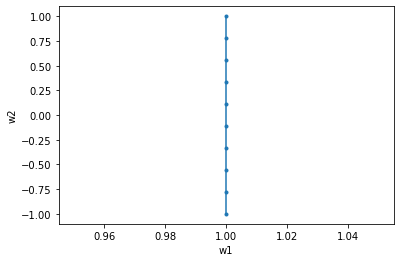

In [0]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

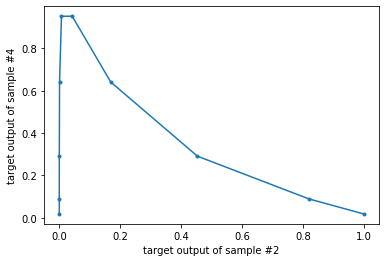

In [0]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 1], subgoals[..., 3], '.-')

In [0]:
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

training_weights = []
predictions = []

def train(model, subgoal, x, learning_rate = 0.01):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return tf.squeeze(model.predict(x))
    
    weight_changes = tf.constant([[-1., -1],
                                  [-1, 0],
                                  [-1, 1],
                                  [0, -1],
                                  [0, 0],
                                  [0, 1],
                                  [1, -1],
                                  [1, 0],
                                  [1, 1]]) * learning_rate
    predict_fn = partial(predict_for_weights, x=x)

    initial_prediction = predict_fn(get_weights())
    training_weights.append(get_weights())
    predictions.append(initial_prediction)

    i = 0
    while True:
        curr_weights = get_weights()
        weight_tests = curr_weights + weight_changes
        prediction_tests = tf.map_fn(predict_fn, weight_tests)
        distances = tf.norm(prediction_tests - subgoal, axis=-1)
        best_index = tf.argmin(distances)
        set_weights(weight_tests[best_index])


        i+=1

        if tf.norm(prediction_tests[best_index] - subgoal) <= .5 * tf.norm(initial_prediction - subgoal):
            print(subgoal, prediction_tests[best_index])
            break
        

        training_weights.append(weight_tests[best_index])
        predictions.append(prediction_tests[best_index])

    
    return i

for i, subgoal in enumerate(subgoals[1:], 1):
    print(i, train(model, subgoal, x))

tf.Tensor([1.000000e+00 3.233403e-06 1.831564e-02 8.894358e-02], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 1.1337244e-06 1.8315639e-02 5.5576157e-02], shape=(4,), dtype=float32)
1 15
tf.Tensor([1.0000000e+00 6.2583284e-05 1.8315639e-02 2.9096046e-01], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 1.6331665e-05 1.8315639e-02 1.7509936e-01], shape=(4,), dtype=float32)
2 19
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/tensorflow-2.1.0/python3.6/tensorflow_core/python/ops/control_flow_ops.py", line 2757, in while_loop
    return result  File "/tensorflow-2.1.0/python3.6/tensorflow_core/python/ops/control_flow_ops.py", line 2705, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/tensorflow-2.1.0/python3.6/tensorflow_core/python/ops/map_fn.py", line 261, in co

KeyboardInterrupt: ignored

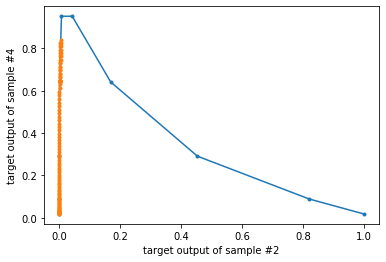

In [0]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 1], subgoals[..., 3], '.-')

# Plot our predictions
#predictions = np.array(logger.predictions).squeeze()
predictions=np.array(predictions)
ax.plot(predictions[..., 1], predictions[..., 3], '.-')

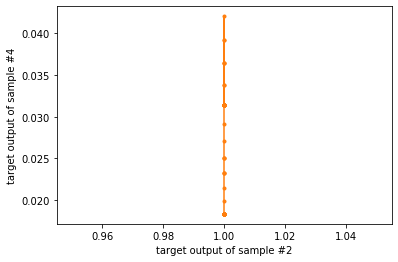

In [0]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

# Plot our predictions
#predictions = np.array(logger.predictions).squeeze()
ax.plot(predictions[..., 0], predictions[..., 2], '.-')

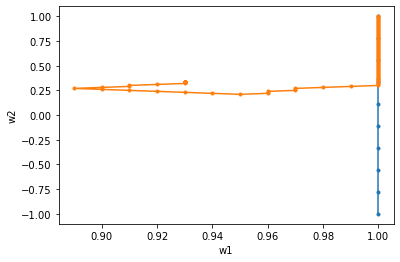

In [0]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

#training_weights = np.array(logger.weights).squeeze()
training_weights = np.array(training_weights).squeeze()
ax.plot(training_weights[..., 0], training_weights[..., 1], '.-')

In [0]:
model.get_weights()

[array([[0.98867995],
        [0.5553148 ]], dtype=float32)]

In [0]:
weights[5]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.        , -0.11111116], dtype=float32)>

In [0]:
# Save data
NUM_SAMPLES = 500

with (DATA_DIR / "sem2_week3_stripe_target_weights.dat").open("w") as f:
    for w in weights.numpy():
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / "sem2_week3_stripe_training_weights.dat").open("w") as f:
    size = training_weights.shape[0]
    for w in training_weights[::size // NUM_SAMPLES]:
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / "sem2_week3_stripe_target_outputs.dat").open("w") as f:
    for s in subgoals.numpy():
        s = s[1], s[3]
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / "sem2_week3_stripe_training_outputs.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions[::size // NUM_SAMPLES]:
        s = s[1], s[3]
        f.write("\t".join(map(str, s)) + "\n")

Text(0, 0.5, 'Loss')

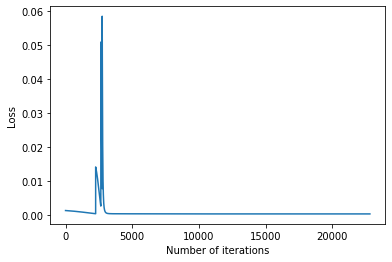

In [0]:
loss_values = list(itertools.chain(*loss))

fig, ax = plt.subplots()
ax.plot(loss_values)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")

In [0]:
predictions

array([[1.0000000e+00, 1.1262837e-07, 1.8315639e-02, 1.8323220e-02],
       [1.0000000e+00, 1.1272164e-07, 1.8315639e-02, 1.8330807e-02],
       [1.0000000e+00, 1.1281498e-07, 1.8315639e-02, 1.8338405e-02],
       ...,
       [1.0000000e+00, 8.8471100e-03, 2.1512855e-02, 9.5484513e-01],
       [1.0000000e+00, 8.8479277e-03, 2.1514572e-02, 9.5484555e-01],
       [1.0000000e+00, 8.8487547e-03, 2.1516290e-02, 9.5484591e-01]],
      dtype=float32)

In [0]:
subgoals

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[1.00000000e+00, 1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.00000000e+00, 3.23340305e-06, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 6.25832836e-05, 1.83156393e-02, 2.90960461e-01],
       [1.00000000e+00, 8.15988577e-04, 1.83156393e-02, 6.41180396e-01],
       [1.00000000e+00, 7.16697192e-03, 1.83156393e-02, 9.51816797e-01],
       [1.00000000e+00, 4.24048156e-02, 1.83156393e-02, 9.51816678e-01],
       [1.00000000e+00, 1.69013351e-01, 1.83156393e-02, 6.41180336e-01],
       [1.00000000e+00, 4.53788817e-01, 1.83156393e-02, 2.90960461e-01],
       [1.00000000e+00, 8.20754826e-01, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 1.00000000e+00, 1.83156393e-02, 1.83156393e-02]],
      dtype=float32)>

In [0]:
deviation_start = np.argwhere(training_weights[..., 0] != 1)[0, 0]
deviation_start

2750

In [0]:
predictions[deviation_start:deviation_start+10]

array([[1.0000000e+00, 2.7552224e-04, 1.8315656e-02, 4.7483337e-01],
       [1.0000000e+00, 2.8812099e-04, 1.8315673e-02, 4.8125541e-01],
       [1.0000000e+00, 3.0113521e-04, 1.8315690e-02, 4.8764533e-01],
       [1.0000000e+00, 3.1456744e-04, 1.8315708e-02, 4.9399951e-01],
       [1.0000000e+00, 3.2841935e-04, 1.8315727e-02, 5.0031441e-01],
       [1.0000000e+00, 3.4269094e-04, 1.8315744e-02, 5.0658667e-01],
       [1.0000000e+00, 3.5738290e-04, 1.8315760e-02, 5.1281309e-01],
       [1.0000000e+00, 3.7249370e-04, 1.8315777e-02, 5.1899058e-01],
       [1.0000000e+00, 3.8802301e-04, 1.8315796e-02, 5.2511626e-01],
       [1.0000000e+00, 4.0396792e-04, 1.8315813e-02, 5.3118736e-01]],
      dtype=float32)

In [0]:
predictions[-10:]

array([[1.        , 0.00884136, 0.02150082, 0.9548424 ],
       [1.        , 0.00884218, 0.02150254, 0.9548428 ],
       [1.        , 0.008843  , 0.02150426, 0.95484316],
       [1.        , 0.00884383, 0.02150598, 0.9548436 ],
       [1.        , 0.00884465, 0.0215077 , 0.95484394],
       [1.        , 0.00884547, 0.02150942, 0.95484436],
       [1.        , 0.00884629, 0.02151114, 0.9548448 ],
       [1.        , 0.00884711, 0.02151285, 0.95484513],
       [1.        , 0.00884793, 0.02151457, 0.95484555],
       [1.        , 0.00884875, 0.02151629, 0.9548459 ]], dtype=float32)

In [0]:
subgoals[5]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.        , 0.04240482, 0.01831564, 0.9518167 ], dtype=float32)>